Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [323]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [324]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, BinaryEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectPercentile
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [325]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

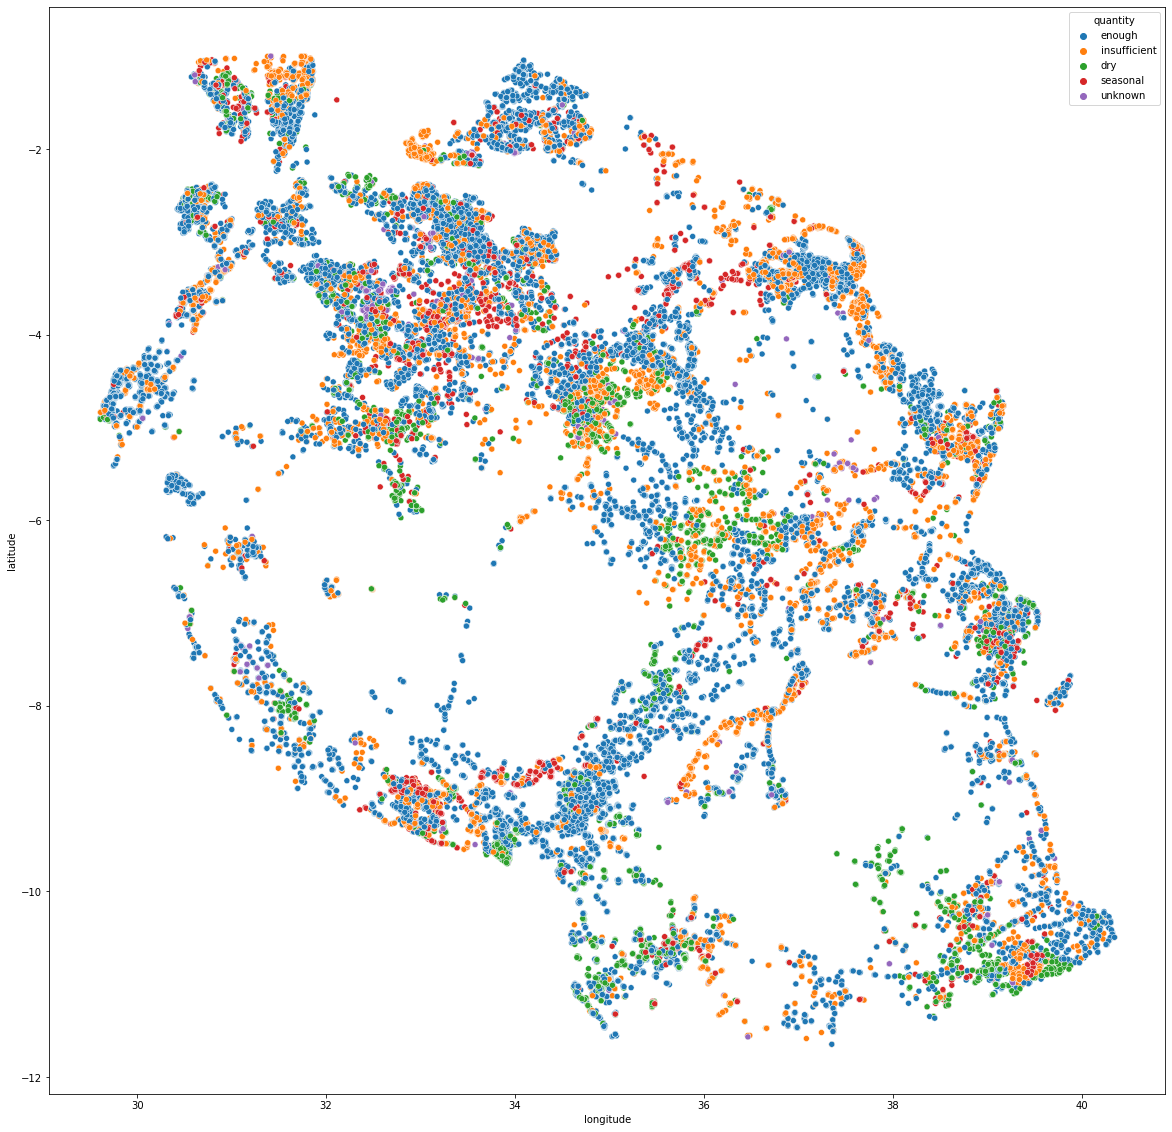

In [326]:
# Let's visualize the geographic location of the watermeters, color coded by whethere there is an construction year

train['latitude'] = train['latitude'].replace(-2e-08, 0)
    
    #Replace 0s with NaNs
cols_with_zeros = ['longitude', 'latitude', 'gps_height', 'population', 'construction_year']
for col in cols_with_zeros:
        train[col] = train[col].replace(0, np.nan)
        train[col+'_MISSING'] = train[col].isnull()
df = train.copy()
df['con_year_missing'] = df['construction_year'].isnull()

plt.figure(figsize=(20, 20))
sns.scatterplot(x = 'longitude', y = 'latitude', data=df, hue='quantity')

/opt/anaconda3/envs/unit_2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gps_height', ylabel='status_group'>

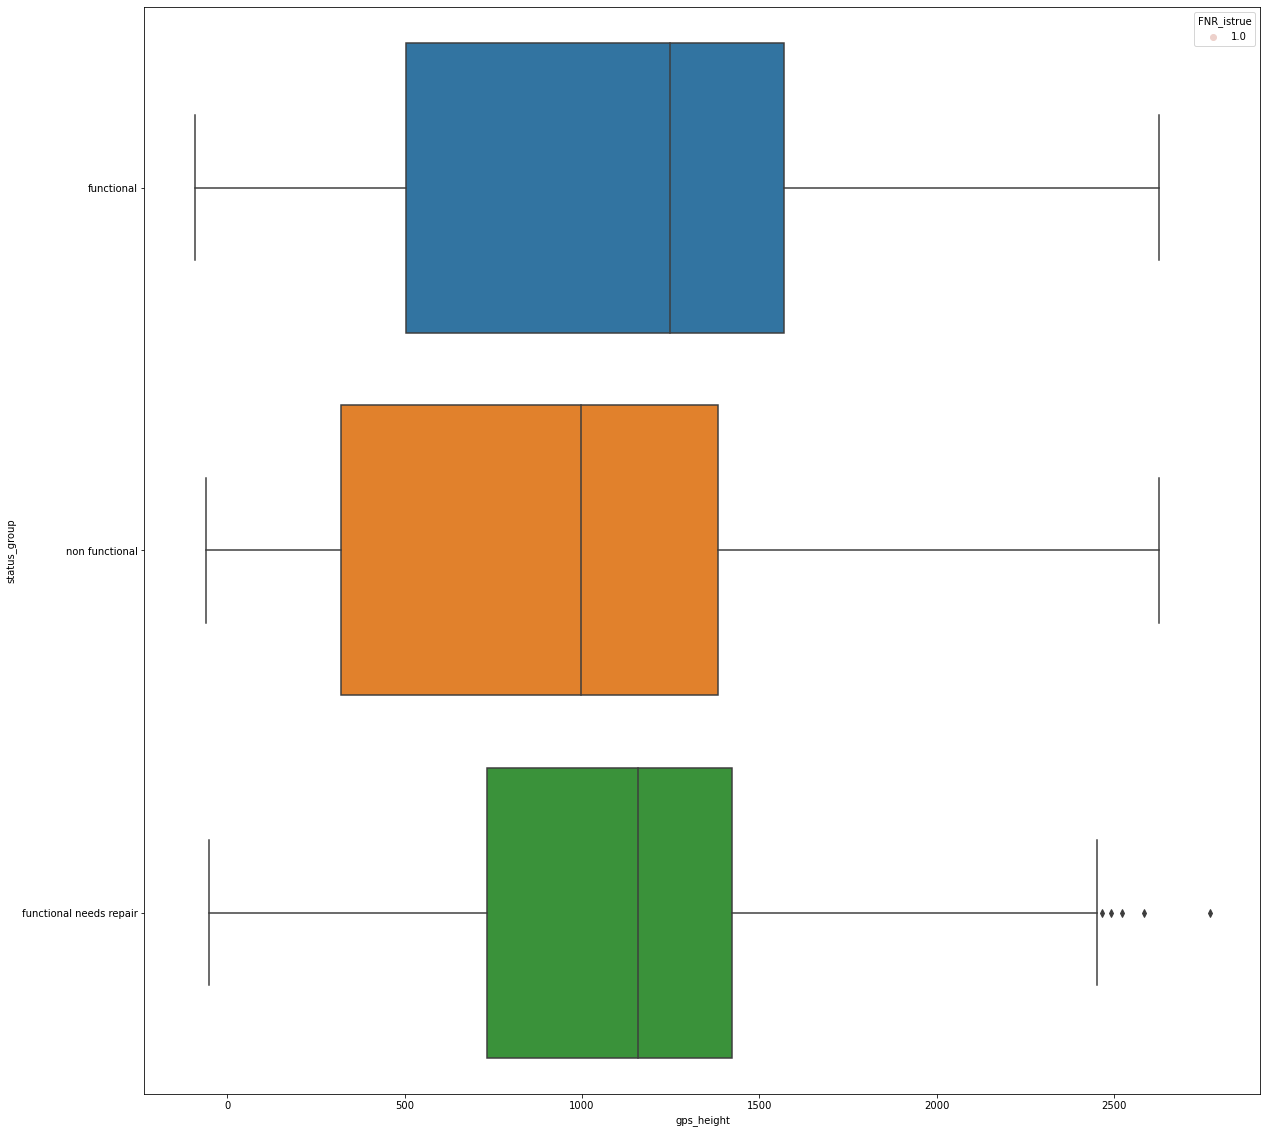

In [327]:
# Our model performs poorls on 'functional needs repair' waterpumps (recall of only ~30%) so let's visualize it
# and see if we can perform some feature engineering

t = train.copy()
t.loc[(t['status_group'] == 'functional needs repair'), 'FNR_istrue'] = 1
t.loc[(t['status_group'] != t['status_group']), 'FNR_istrue'] = 0
plt.figure(figsize=(20, 20))
sns.scatterplot(x = 'longitude', y = 'latitude', data=t, hue='FNR_istrue')

sns.boxplot(t['gps_height'], t['status_group'])

In [328]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

def wrangle(X):
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Set ID as index
    X = X.set_index('id')
    
    #Replace close to zeros with zeros
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    #Replace 0s with NaNs
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        

    # Drop duplicate columns
    # reconsider: installer vs funder; water_quality vs quality_group; 'extraction_type_class' vs  'extraction_type_group' vs 'extraction_type'
    duplicates = ['quantity_group', 'payment_type'#, 'waterpoint_type_group', 'installer', 'quality_group',
                 #'extraction_type_group', 'extraction_type_class'
                 ]
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies)
    unusable_variance = ['recorded_by']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # Engineer feature:
    # Getting the range of longitude and latitudes in dataset
    long_min = X.describe().loc['min', 'longitude']
    long_max = X.describe().loc['max', 'longitude']
    lat_min = X.describe().loc['min', 'latitude']
    lat_max = X.describe().loc['max', 'latitude']
    lat_range = lat_max - lat_min
    long_range = long_max - long_min

    # Creating N regions
    n = 100
    lat_step = lat_range/np.sqrt(n) 
    lon_step = long_range/np.sqrt(n) 
    to_lat_bin = lambda x: np.floor(x / lat_step) * lat_step
    to_lon_bin = lambda x: np.floor(x / lon_step) * lon_step
    
    # Add a bunch of regions as strings
    X["latbin"] = X.latitude.map(to_lat_bin)
    X["lonbin"] = X.longitude.map(to_lon_bin)
    X["latbin"] = X["latbin"].astype(str)
    X["lonbin"] = X["latbin"].astype(str)
    
    # Trying another feature
    X['years_squared'] = X['years']**2
    
    # Cleaning done to fix warnings in profile_report()
    # High cardinality
    # Kept amount_tsh
    # reconsider 'subvillage',
    to_drop = ['wpt_name', 'num_private'] 
    X = X.drop(columns=to_drop)
    
    # Preserve top 50 of the classes in these features, make the rest 'Other'
    k = 49
    def top_ten_other(f_list):
        for i in f_list:
            class_list = X[i].value_counts().index.tolist()
            top = class_list[:k]
            X[i] = [i if i in top else 'Other' for i in X['funder']]
            
    # Consolidate classes
    cons_class = ['funder', 'installer', 'scheme_name']
    #top_ten_other(cons_class)
               
    # Getting the range of longitude and latitudes in dataset
    long_min = X.describe().loc['min', 'longitude']
    long_max = X.describe().loc['max', 'longitude']
    lat_min = X.describe().loc['min', 'latitude']
    lat_max = X.describe().loc['max', 'latitude']

    lat_range = lat_max - lat_min
    long_range = long_max - long_min
    
    # Creating N regions
    n = 100
    lat_step = lat_range/np.sqrt(n) 
    lon_step = long_range/np.sqrt(n) 
    to_lat_bin = lambda x: np.floor(x / lat_step) * lat_step
    to_lon_bin = lambda x: np.floor(x / lon_step) * lon_step

    #Creating the bins
    X["latbin"] = X.latitude.map(to_lat_bin)
    X["lonbin"] = X.longitude.map(to_lon_bin)
    X["latbin"] = X["latbin"].astype(str)
    X["lonbin"] = X["latbin"].astype(str)
    
    # FEATURE ENGINEERING: imputing construction year better
    # Let's find the average construction year of all the regions
    regions = train['region'].value_counts().index.tolist()
    region_dict = {}
    for i in regions:
        region_dict[i] = train[train['region'] == i]['construction_year'].mean()
        
    # To impute missing values, I will average the construction year of adjacent regions
    region_dict['Mbeya'] = np.mean([region_dict['Rukwa'], region_dict['Iringa']])
    region_dict['Kagera'] = np.mean([region_dict['Mwanza'], region_dict['Mara']])
    region_dict['Dodoma'] = np.mean([region_dict['Singida'], region_dict['Manyara'], region_dict['Morogoro'], region_dict['Iringa']])
    region_dict['Tabora'] = np.mean([region_dict['Singida'], region_dict['Shinyanga']])    
    
    Xr = X.reset_index()
    X['construction_year'] = [region_dict[Xr.loc[int(j), 'region']].astype(int) if (Xr.loc[int(j), 'construction_year'] != Xr.loc[int(j), 'construction_year']) else Xr.loc[int(j), 'construction_year'] for j in range(Xr['construction_year'].size)]

    # FEATURE ENGINEERING: imputing POPULATION better
    # Let's find the average construction year of all the regions
    regions = train['region'].value_counts().index.tolist()
    region_dict = {}
    for i in regions:
        region_dict[i] = train[train['region'] == i]['population'].mean()
        
    # To impute missing values, I will average the POPULATION of adjacent regions
    region_dict['Mbeya'] = np.mean([region_dict['Rukwa'], region_dict['Iringa']])
    region_dict['Kagera'] = np.mean([region_dict['Mwanza'], region_dict['Mara']])
    region_dict['Dodoma'] = np.mean([region_dict['Singida'], region_dict['Manyara'], region_dict['Morogoro'], region_dict['Iringa']])
    region_dict['Tabora'] = np.mean([region_dict['Singida'], region_dict['Shinyanga']])    

    Xr = X.reset_index()
    #X['population'] = [region_dict[Xr.loc[int(j), 'region']].astype(float) if (Xr.loc[int(j), 'population'] != Xr.loc[int(j), 'population']) else Xr.loc[j, 'population'] for j in range(Xr['population'].size)]
    region_dict = {}
    
    # FEATURE ENGINEERING: imputing GPS_HEIGHT better
    # Let's find the average construction year of all the regions
    regions = train['region'].value_counts().index.tolist()
    region_dict = {}
    for i in regions:
        region_dict[i] = train[train['region'] == i]['gps_height'].mean()  
    
    # To impute missing values, I will average the GPS_HEIGHT of adjacent regions
    region_dict['Mbeya'] = 1700
    region_dict['Kagera'] = 1700
    region_dict['Dodoma'] = 1120
    region_dict['Tabora'] = 1200  
    
    Xr = X.reset_index()
    #X['gps_height'] = [region_dict[Xr.loc[int(j), 'region']] if (Xr.loc[int(j), 'gps_height'] != Xr.loc[int(j), 'gps_height']) else Xr.loc[int(j), 'gps_height'] for j in range(Xr['gps_height'].size)]
    region_dict = {}
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [329]:
pd.crosstab(train['quantity'], train['status_group'])

status_group,functional,functional needs repair,non functional
quantity,,,
dry,128,31,4762
enough,17293,1915,7359
insufficient,6333,1168,4652
seasonal,1883,328,1033
unknown,170,12,453


In [330]:
train['quantity'].value_counts()

enough          26567
insufficient    12153
dry              4921
seasonal         3244
unknown           635
Name: quantity, dtype: int64

In [331]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
low_card_features = cardinality[cardinality <= 50].index.tolist()

# Get a list of all categorical features with cardinality > 50
high_card_features = cardinality[cardinality > 50].index.tolist()

In [332]:
train_features.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'longitude_MISSING',
       'latitude_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'construction_year_MISSING', 'year_recorded', 'month_recorded',
       'day_recorded', 'years', 'years_MISSING', 'latbin', 'lonbin',
       'years_squared'],
      dtype='object')

In [310]:
#Checking the most correlated variables with status_group

oe = OrdinalEncoder()
train_num = oe.fit_transform(train)
corr_matrix = train_num.corr()
print(corr_matrix["status_group"].sort_values(ascending=False)[:10])

status_group             1.000000
waterpoint_type_group    0.214924
construction_year        0.174039
waterpoint_type          0.162789
quantity                 0.145721
gps_height               0.128285
scheme_management        0.107891
payment                  0.099210
source_class             0.086632
extraction_type_group    0.076016
Name: status_group, dtype: float64


In [333]:
# YOUR CODE HERE
X_train = train[train_features.columns]
X_val = val[train_features.columns]
y_train = train[target]
y_val = val[target]
X_test = test[train_features.columns]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((47520, 46), (47520,), (11880, 46), (11880,), (14358, 46))

In [334]:
train_features.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'longitude_MISSING',
       'latitude_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'construction_year_MISSING', 'year_recorded', 'month_recorded',
       'day_recorded', 'years', 'years_MISSING', 'latbin', 'lonbin',
       'years_squared'],
      dtype='object')

In [313]:
# Preprocess target data

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [335]:
# BEST ATTEMPT!
# Doing ordinal encoding for all variables

# Set up our preprocessor/column transformer
o_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', o_transformer, train_features.columns)
    ])

# Set up the pipeline
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('randomforestclassifier', RandomForestClassifier(criterion = 'gini',
                                                      n_estimators = 188,
                                                      n_jobs = -1))]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'cons...
       'waterpoint_type', 'waterpoint_type_group', 'longitude_MISSING',
       'latitude_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'construction_year_MISSING', 'year_recorded', 'month_recorded',
       'day_recorded', 'years', 'years_MISSING', 'latbin', 'lonbin',
       'years_squared'],
      dtype='object'))])),
                ('simpleimputer', SimpleImputer(strategy='median')),
               

In [336]:
print('Val accuracy = ', pipeline.score(X_val, y_val))

Val accuracy =  0.811952861952862


In [288]:
# Trying to get the distribution of y_pred
# Note there are three target classes

y_pred_proba = pipeline.predict_proba(X_val)
y_pred_proba

array([[0.17553191, 0.        , 0.82446809],
       [0.06382979, 0.78191489, 0.15425532],
       [0.4787234 , 0.20212766, 0.31914894],
       ...,
       [0.09574468, 0.        , 0.90425532],
       [0.7393617 , 0.10638298, 0.15425532],
       [0.38829787, 0.05319149, 0.55851064]])

/opt/anaconda3/envs/unit_2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: Data must be 1-dimensional

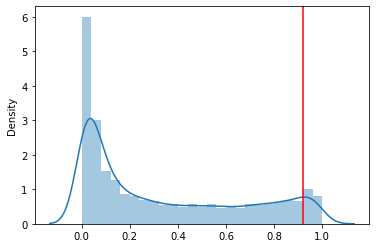

In [289]:
threshold = 0.92
y_pred = y_pred_proba > threshold
ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color = 'red')
pd.Series(y_pred).value_counts()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, values_format = '.1f', xticks_rotation=45);

In [290]:
# Classification report
y_pred = pipeline.predict(X_val)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4129
           1       0.59      0.30      0.40       553
           2       0.82      0.78      0.80      2922

    accuracy                           0.80      7604
   macro avg       0.74      0.65      0.68      7604
weighted avg       0.79      0.80      0.79      7604



In [291]:
#Getting Kaggle submissions
y_pred = pd.DataFrame(pipeline.predict(X_test))

submission = y_pred
submission.set_index(X_test.index, inplace=True)
submission.rename(columns={0:'status_group'}, inplace=True)
submission.head()

submission.to_csv('RF_best.csv')

In [20]:
# Trying randomized search CV
# This didn't improve the model...


In [89]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]

## Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5]


o_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', o_transformer, train_features.columns)
    ])



# Create the random grid

random_grid = {#'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_depth': max_depth#,
               #'randomforestclassifier__min_samples_split': min_samples_split,
               #'randomforestclassifier__min_samples_leaf': min_samples_leaf
}
print(random_grid)                     

# Put the model together

model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('randomforestclassifier', RandomForestClassifier(criterion = 'gini',
                                                      n_estimators = 188,
                                                      n_jobs = -1))]
)

search = RandomizedSearchCV(
    model, 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
#    verbose=10, 
#    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

{'randomforestclassifier__max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, None]}


/opt/anaconda3/envs/unit_2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
search.best_params_ 

In [ ]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
low_card_features = cardinality[cardinality <= 50].index.tolist()

# Get a list of all categorical features with cardinality > 50
high_card_features = cardinality[cardinality > 50].index.tolist()

In [ ]:
best_pipeline = search.best_estimator_
y_pred = best_pipeline.predict(X_val)
best_pipeline.score(X_val, y_val)

In [83]:
# Trying XGBoost

model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('classifier', XGBClassifier(n_jobs = -1,
                                objective = 'binary:logistic'))])

model.fit(X_train, y_train, classifier__eval_metric='error')

/opt/anaconda3/envs/unit_2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1,
              

In [84]:
print('Val accuracy = ', model.score(X_val, y_val))

Val accuracy =  0.8015993265993266


In [130]:
train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'longitude_MISSING',
       'latitude_MISSING', 'gps_height_MISSING', 'population_MISSING',
       'construction_year_MISSING', 'year_recorded', 'month_recorded',
       'day_recorded', 'years', 'years_MISSING', 'latbin', 'lonbin',
       'years_squared'],
      dtype='object')

In [151]:
cols = ['basin', 'subvillage', 'region', 'lga']
pca_cols = train[cols]
oe = OrdinalEncoder()
pca_cols = oe.fit_transform(pca_cols)
pca = PCA()

new_cols = pca.fit_transform(pca_cols)
new_cols = pd.DataFrame(new_cols)

new_cols

,0,1,2,3
0,-5579.899366,-48.157906,6.512113,2.454497
1,-5578.899190,-47.099625,5.468704,1.565121
2,-5577.899013,-46.041345,4.425296,0.675745
3,-5576.898837,-44.983064,3.381887,-0.213630
4,-5575.898661,-43.924784,2.338479,-1.103006
...,...,...,...,...
47515,2354.103781,-21.449849,-1.208399,-2.356054
47516,-4508.895281,-4.316402,8.771637,2.715159
47517,-3494.888764,58.983720,3.228908,-4.078564
47518,-4845.888755,59.113641,3.148240,-4.097020


In [152]:
train2 = train.copy()
for i in range(len(new_cols)):
    train2[cols[i] + '_PCA'] = new_cols[i]
train2

KeyError: 4

In [143]:
# PCA Analysis

o_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
pca_transformer = Pipeline(steps=[('pca', PCA())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', o_transformer, train_features.columns),
        ('pca', pca_transformer, pca_cols)
    ])

# Set up the pipeline
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('simpleimputer', SimpleImputer(strategy='median')),
    ('randomforestclassifier', RandomForestClassifier(criterion = 'gini',
                                                      n_estimators = 188,
                                                      n_jobs = -1))]
)

In [144]:
print('Val accuracy = ', pipeline.score(X_val, y_val))

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Getting Kaggle submissions
y_pred = pd.DataFrame(model.predict(X_test))

submission = y_pred
submission.set_index(X_test.index, inplace=True)
submission.rename(columns={0:'status_group'}, inplace=True)
submission.head()

submission.to_csv('XGB_best.csv')

In [ ]:
print('Val accuracy = ', model.score(X_val, y_val))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = pipeline.predict(X_val)
cm = confusion_matrix(y_val, y_pred, labels = y_val.unique())
ConfusionMatrixDisplay(cm, display_labels = y_val.unique()).plot()

In [115]:
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['XGB_best.csv', 'RF_best.csv', 'classroom_best.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)

In [116]:
tt = pd.read_csv('my-ultimate-ensemble-submission.csv')
tt.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [90]:
# Check out the column names post-preprocessor
preprocessor = pipeline.named_steps['preprocessor'].named_transformers_['ordinal']
pre_processor_cols = preprocessor.transform(X_val).columns
all_cols = X_train.columns.append(pre_processor_cols)
len(pre_processor_cols)

45

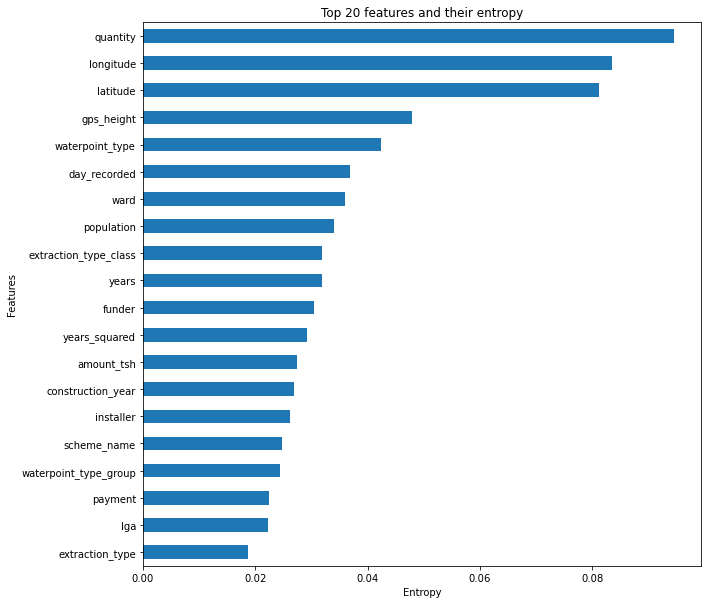

In [91]:
# Get the feature inportances

rf = pipeline.named_steps['randomforestclassifier']
n=20
plt.figure(figsize = (10, n/2))
plt.title(f'Top {n} features and their entropy')
plt.xlabel('Entropy')
plt.ylabel('Features')
importances = pd.Series(rf.feature_importances_, pre_processor_cols)
importances.sort_values()[-n:].plot.barh();

In [102]:
# Trying to do determine how I can improve the model further

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = pipeline.predict(X_val)
cm = confusion_matrix(y_val, y_pred, labels = y_val.unique())
ConfusionMatrixDisplay(cm, display_labels = y_val.unique()).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'